# Loan Prediction III Data competition

link: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

I have done the data preparation and Machine learning algorithm. However, the accuracy of the prediction and cross-validation have never reached 90%. Therefore, in this exercise I will attempt to improve the algorithm performance with GBM and XGBoost methods.

We will start with GBM methods

# A. Gradient Boosting Method (GBM)

Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The **outcomes predicted correctly** are given a **lower weight** and the **ones miss-classified** are **weighted higher**. This technique is followed for a classification problem while a similar technique is used for regression.

## 1. GBM Parameters

The overall parameters can be divided into 3 categories:

- **Tree-Specific Parameters**: These affect each individual tree in the model.
- **Boosting Parameters**: These affect the boosting operation in the model.
- **Miscellaneous Parameters**: Other parameters for overall functioning.

### 1.1 Tree-Specific Parameters
1. **min_samples_split**
    - Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
    - Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
    - Too high values can lead to under-fitting hence, it should be tuned using CV.
2. **min_samples_leaf**
    - Defines the minimum samples (or observations) required in a terminal node or leaf.
    - Used to control over-fitting similar to min_samples_split.
    - Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
3. **min_weight_fraction_leaf**
    - Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.
    - Only one of #2 and #3 should be defined.
4. **max_depth**
    - The maximum depth of a tree.
    - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Should be tuned using CV.
5. **max_leaf_nodes**
    - The maximum number of terminal nodes or leaves in a tree.
    - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
    - If this is defined, GBM will ignore max_depth.
6. **max_features**
    - The number of features to consider while searching for a best split. These will be randomly selected.
    - As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
    - Higher values can lead to over-fitting but depends on case to case.
    
**Pseudo-code of the GBM algorithm for 2 classes:
1. Initialize the outcome
2. Iterate from 1 tototal number of trees
    2.1 Update the weights for targets based on previous run (higher for the one mis-classfied)
    2.2 Fit the model on selected subsample of data
    2.3 Make predictions on the full set of obserations
    2.4 Update the output with current results taking into account the learning rate
3. Return the final output

**Note**: Above, is an extremely simplified (probably naive) explanation of GBM's working. The parameters which we have considered so far will affect step 2.2, i.e. model building. Next is we consider another set of parameters for managing boosting:

### 1.2 Boosting Parameters
1. **learning_rate**
    - This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
    - Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
    - Lower values would require higher number of trees to model all the relations and will be computationally expensive.
2. **n_estimators**
    - The number of sequential trees to be modeled (step 2)
    - Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.
3. **subsample**
    - The fraction of observations to be selected for each tree. Selection is done by random sampling.
    - Values slightly less than 1 make the model robust by reducing the variance.
    - Typical values ~0.8 generally work fine but can be fine-tuned further.

Finally, other miscellaneous parameters which affect the overall functionality.

### 1.3 Miscellaneous Parameters
1. **loss**
    - It refers to the loss function to be minimized in each split.
    - It can have various values for classification and regression case. Generally the default values work fine. Other values should be chosen only if you understand their impact on the model.
2. **init**
    - This affects initialization of the output.
    - This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.
3. **random_state**
    - The random number seed so that same random numbers are generated every time.
    - This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
    - It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.
4. **verbose**
    - The type of output to be printed when the model fits. The different values can be:
        - 0: no output generated (default)
        - 1: output generated for trees in certain intervals
        - >1: output generated for all trees
5. **warm_start**
    - This parameter has an interesting application and can help a lot if used judicially.
    - Using this, we can fit additional trees on previous fits of a model. It can save a lot of time and you should explore this option for advanced applications
6. **presort **
    - Select whether to presort data for faster splits.
    - It makes the selection automatically by default but it can be changed if needed.

## 2. Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#Load data:
train = pd.read_csv(r'C:\Users\LW130003\Documents\GitHub\loan-prediction-iii\train_modified.csv')
test = pd.read_csv(r'C:\Users\LW130003\Documents\GitHub\loan-prediction-iii\test_modified.csv')

target = 'Loan_Status'

train.shape, test.shape

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


((614, 16), (367, 15))

In [2]:
train.dtypes

ApplicantIncome           int64
CoapplicantIncome       float64
Credit_History          float64
Dependents                int64
Education                 int64
Gender                    int64
LoanAmount              float64
Loan_Amount_Term        float64
Loan_Status               int64
Married                   int64
Property_Area             int64
Self_Employed             int64
LoanAmount_log          float64
Loan_Amount_Term_log    float64
TotalIncome             float64
TotalIncome_log         float64
dtype: object

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 15 columns):
ApplicantIncome         367 non-null int64
CoapplicantIncome       367 non-null float64
Credit_History          367 non-null float64
Dependents              367 non-null int64
Education               367 non-null int64
Gender                  367 non-null int64
LoanAmount              367 non-null float64
Loan_Amount_Term        367 non-null float64
Married                 367 non-null int64
Property_Area           367 non-null int64
Self_Employed           367 non-null int64
LoanAmount_log          367 non-null float64
Loan_Amount_Term_log    367 non-null float64
TotalIncome             367 non-null float64
TotalIncome_log         367 non-null float64
dtypes: float64(8), int64(7)
memory usage: 43.1 KB


In [4]:
train['Loan_Status'].value_counts()
# For mapping the Y-> 1, N -> 0, but this step is skipped after one hot encoding in data preparation
# train['Loan_Status'] = train['Loan_Status'].astype(str).map({'Y':1,'N':0}).astype(float)
# train['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

## 3. General Function for modeling and cross-validation
This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. perform CV is performCV is True
6. plot Feature Importance if printFeatureImportance is True

**Note**: 
1. Evaluation Metric is accuracy i.e. percentage of loan approval you correctly predict.
2. You are expected to upload the solution in the format of "sample_submission.csv"

Useful Link for helping creating the general function:
1. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
2. http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
3. http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

**Note 2**:
- Loan_Status need to be converted to float from Y -> 1 and N -> 0 for the code below to works.

In [5]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Loan_Status'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Loan_Status'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Loan_Status'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Loan_Status'], dtrain_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### 3.1 Baseline Model
Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.

**Note**:
- Baseline model is a model that is used as a benchmark or foundation for measuring or comparing current and past values.


Model Report
Accuracy : 0.8941
AUC Score (Train): 0.978111
CV Score : Mean - 0.7497445 | Std - 0.03959329 | Min - 0.6889894 | Max - 0.8131266


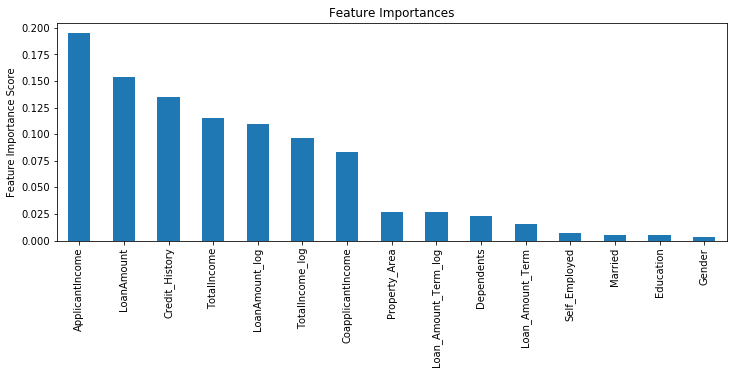

In [6]:
#Choose all predictors except target
predictors = [x for x in train.columns if x not in target]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, test, predictors)

## 3.2 Tuning the Parameters
There 2 types of parameters here:
1. **Boosting specific paramters**
    - **n_estimators**
    - **learning_rate**
    - **subsample**
2. **Tree-specific parameters**
    - **min_samples_split**
    - **min_samples_leaf**
    - **max_depth**
    - **min_leaf_nodes**
    - **max_features**
    - **loss function**
   
### 3.2.1 General Approach for Parameter Tuning
1. Choose a relatively **high learning rate**. Generally the default value f 0.1 works but somewhere between 0.05 to 0.2 should work for different problems.

2. Determine the **optimum number of trees for this learning rate**. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.

3. **Tune tree-specific parameters** for decided learning rate and number of trees. Note that we can choose different parameters to define a tree.

4. **Lower the learning rate** and increase the estimators proportionally to get more robust models.
**Fix learning rate and number of estimators for tuning tree-based parameters**

#### First Attempt:
1. **min_samples_split = 5** : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
2. **min_samples_leaf = 50** : Just using for preventing overfitting. will be tuned later.
3. **max_depth = 8** : since high number of observations and predictors, choose relatively high value
4. **max_features = 'sqrt'** : general thumbrule to start with
5. **subsample = 0.8** : typically used value (will be tuned later)

**Note**: 
- Imbalanced data sets are a special case for classification problem where the class distribution is not uniform among the classes. Typically, they are composed by two classes: The majority (negative) class and the minority (positive) class.

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {'n_estimators':list(range(20,81,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=5,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.75929, std: 0.02687, params: {'n_estimators': 20},
  mean: 0.76763, std: 0.02733, params: {'n_estimators': 30},
  mean: 0.76854, std: 0.02862, params: {'n_estimators': 40},
  mean: 0.76972, std: 0.03035, params: {'n_estimators': 50},
  mean: 0.76938, std: 0.03009, params: {'n_estimators': 60},
  mean: 0.76885, std: 0.03374, params: {'n_estimators': 70},
  mean: 0.76827, std: 0.03256, params: {'n_estimators': 80}],
 {'n_estimators': 50},
 0.7697199446580252)

We got 50 as the optimal estimators for 0.1 learning rate.

**Note**: 
- If the value is around 20, you may want to try lowering the learning rate (to 0.05) and re-run grid search.
- If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate.

### 3.2.2 Tuning tree-specific parameters
In this section, we are going to:
1. Tune max_depth and num_sample_split
2. Tune min_sample_leaf
3. Tune max_features

The **order of tuning** variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we're tuning those first.

We start with max_depth of 5 to 15 in steps of 1 and min_samples_split from 2 to 10 in steps of 2.

In [8]:
param_test2 = {'max_depth':list(range(5,16,2)),'min_samples_split':list(range(2,10,2))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, 
                                                              max_features='sqrt', subsample=0.8, 
                                                              random_state=10), 
                       param_grid=param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_,gsearch2.best_params_,gsearch2.best_score_

([mean: 0.75878, std: 0.03263, params: {'max_depth': 5, 'min_samples_split': 2},
  mean: 0.75641, std: 0.04330, params: {'max_depth': 5, 'min_samples_split': 4},
  mean: 0.77400, std: 0.03245, params: {'max_depth': 5, 'min_samples_split': 6},
  mean: 0.76771, std: 0.04024, params: {'max_depth': 5, 'min_samples_split': 8},
  mean: 0.76347, std: 0.04089, params: {'max_depth': 7, 'min_samples_split': 2},
  mean: 0.76421, std: 0.04096, params: {'max_depth': 7, 'min_samples_split': 4},
  mean: 0.75406, std: 0.04820, params: {'max_depth': 7, 'min_samples_split': 6},
  mean: 0.76599, std: 0.03653, params: {'max_depth': 7, 'min_samples_split': 8},
  mean: 0.76241, std: 0.04131, params: {'max_depth': 9, 'min_samples_split': 2},
  mean: 0.76263, std: 0.03455, params: {'max_depth': 9, 'min_samples_split': 4},
  mean: 0.76138, std: 0.05218, params: {'max_depth': 9, 'min_samples_split': 6},
  mean: 0.76337, std: 0.04539, params: {'max_depth': 9, 'min_samples_split': 8},
  mean: 0.77657, std: 0.0335

The ideal value are 11 for max_depth and 2 for min_samples_split. Next, we'll test the min_sample_leaf, from 20 to 70 in steps of 10, along with higher min_samples_split.

In [9]:
param_test3 = {'min_samples_split':list(range(2,11,2)), 'min_samples_leaf':list(range(20,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, 
                                                               max_depth = 11, max_features='sqrt', 
                                                               subsample=0.8, random_state=10), 
                       param_grid=param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_,gsearch3.best_params_,gsearch3.best_score_

([mean: 0.75341, std: 0.05148, params: {'min_samples_leaf': 20, 'min_samples_split': 2},
  mean: 0.75341, std: 0.05148, params: {'min_samples_leaf': 20, 'min_samples_split': 4},
  mean: 0.75341, std: 0.05148, params: {'min_samples_leaf': 20, 'min_samples_split': 6},
  mean: 0.75341, std: 0.05148, params: {'min_samples_leaf': 20, 'min_samples_split': 8},
  mean: 0.75341, std: 0.05148, params: {'min_samples_leaf': 20, 'min_samples_split': 10},
  mean: 0.75049, std: 0.03633, params: {'min_samples_leaf': 30, 'min_samples_split': 2},
  mean: 0.75049, std: 0.03633, params: {'min_samples_leaf': 30, 'min_samples_split': 4},
  mean: 0.75049, std: 0.03633, params: {'min_samples_leaf': 30, 'min_samples_split': 6},
  mean: 0.75049, std: 0.03633, params: {'min_samples_leaf': 30, 'min_samples_split': 8},
  mean: 0.75049, std: 0.03633, params: {'min_samples_leaf': 30, 'min_samples_split': 10},
  mean: 0.75283, std: 0.03712, params: {'min_samples_leaf': 40, 'min_samples_split': 2},
  mean: 0.75283, st


Model Report
Accuracy : 0.8094
AUC Score (Train): 0.892168
CV Score : Mean - 0.7697199 | Std - 0.03034915 | Min - 0.7384085 | Max - 0.8148496


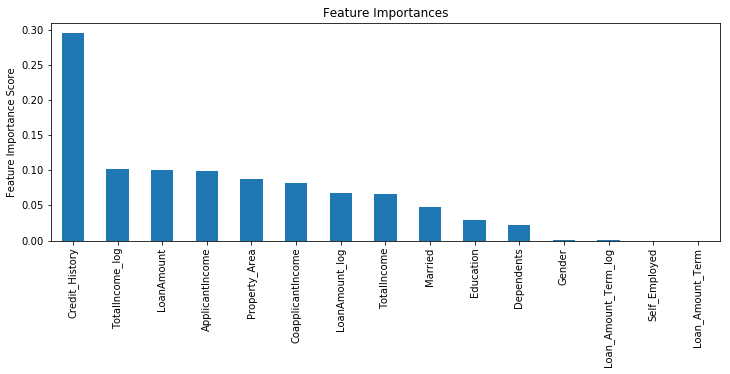

In [10]:
modelfit(gsearch3.best_estimator_,train,test,predictors)

The optimum value is 2 for min_samples_split and 50 for min_samples_leaf and the CV score drop to 0.7697199. let's look at the feature importance. Now, we'll tune the last tree-parameters, i.e. max_features by trying values from 1 to 17 in steps of 1.

In [11]:
param_test4 = {'max_features':list(range(1,12,1))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, 
                                                               max_depth = 11, max_features='sqrt',
                                                               min_samples_split = 2, min_samples_leaf = 50,
                                                               subsample=0.8, random_state=10), 
                       param_grid=param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_,gsearch4.best_params_,gsearch4.best_score_

([mean: 0.74889, std: 0.02951, params: {'max_features': 1},
  mean: 0.75812, std: 0.03313, params: {'max_features': 2},
  mean: 0.76972, std: 0.03035, params: {'max_features': 3},
  mean: 0.75448, std: 0.02792, params: {'max_features': 4},
  mean: 0.76083, std: 0.03188, params: {'max_features': 5},
  mean: 0.75469, std: 0.03813, params: {'max_features': 6},
  mean: 0.75452, std: 0.03380, params: {'max_features': 7},
  mean: 0.75619, std: 0.03175, params: {'max_features': 8},
  mean: 0.75630, std: 0.03209, params: {'max_features': 9},
  mean: 0.76418, std: 0.03614, params: {'max_features': 10},
  mean: 0.75388, std: 0.02838, params: {'max_features': 11}],
 {'max_features': 3},
 0.7697199446580252)


Model Report
Accuracy : 0.8094
AUC Score (Train): 0.892168
CV Score : Mean - 0.7697199 | Std - 0.03034915 | Min - 0.7384085 | Max - 0.8148496


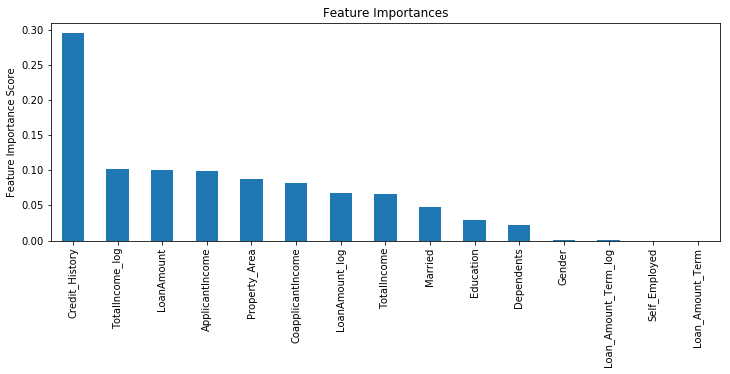

In [12]:
modelfit(gsearch4.best_estimator_,train,test,predictors)

The optimum value is 4. The final tree parameters:
- min_samples_split : 2
- min_samples_leaf : 50
- max_depth : 11
- max_features: 3

### 3.2.3 Tuning subsample and making models with lower learning rate

The next step is to try different subsamples values. Let's take values 0.6, 0.7, 0.75, 0.8, 0.85, 0.9.

In [13]:
param_test5 = {'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, 
                                                               max_depth = 11, min_samples_split = 2, 
                                                               min_samples_leaf = 50, subsample=0.8, 
                                                               random_state=10, max_features=3), 
                       param_grid=param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_,gsearch5.best_params_,gsearch5.best_score_

([mean: 0.60572, std: 0.06341, params: {'subsample': 0.6},
  mean: 0.75326, std: 0.01660, params: {'subsample': 0.7},
  mean: 0.76524, std: 0.03238, params: {'subsample': 0.75},
  mean: 0.76972, std: 0.03035, params: {'subsample': 0.8},
  mean: 0.76057, std: 0.02946, params: {'subsample': 0.85},
  mean: 0.76057, std: 0.03527, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.7697199446580252)

The optimum value is 0.8. Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not the most optimum values but a good benchmark.

As tree increases, it will become incresingly computationally expensive to perform CV and find the optimum values.

First, we will decrease the learning rate by half (0.05) with twice (100) number of trees.


Model Report
Accuracy : 0.8111
AUC Score (Train): 0.899079
CV Score : Mean - 0.7617537 | Std - 0.03391644 | Min - 0.7294118 | Max - 0.8161028


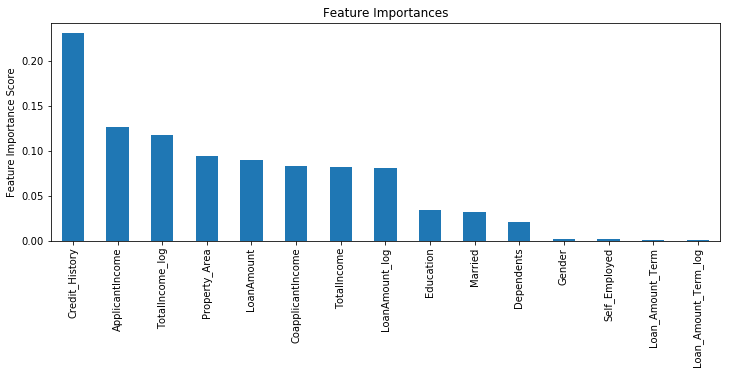

In [14]:
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, 
                                        max_depth = 11, min_samples_split = 2, 
                                        min_samples_leaf = 50, subsample=0.8, 
                                        random_state=10, max_features=3)
modelfit(gbm_tuned_1,train,test,predictors)


Model Report
Accuracy : 0.8111
AUC Score (Train): 0.902165
CV Score : Mean - 0.7607513 | Std - 0.02685009 | Min - 0.7359023 | Max - 0.808584


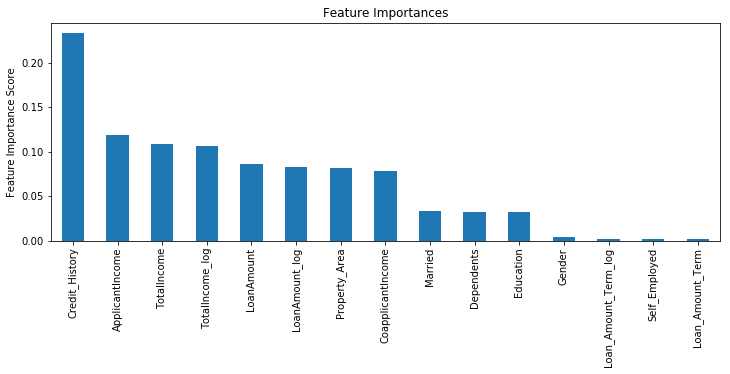

In [15]:
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, 
                                        max_depth = 11, min_samples_split = 2, 
                                        min_samples_leaf = 50, subsample=0.8, 
                                        random_state=10, max_features=3)
modelfit(gbm_tuned_2,train,test,predictors)

Next, we will reduce the learning rate to **one-twentieth**, i.e. 0.005 for 1000 trees.


Model Report
Accuracy : 0.8111
AUC Score (Train): 0.902424
CV Score : Mean - 0.7605401 | Std - 0.02985708 | Min - 0.7243108 | Max - 0.8126566


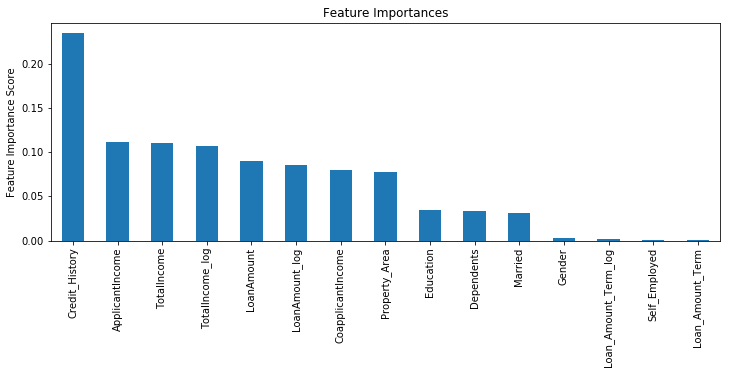

In [16]:
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1000, 
                                        max_depth = 11, min_samples_split = 2, 
                                        min_samples_leaf = 50, subsample=0.8, 
                                        random_state=10, max_features=3)
modelfit(gbm_tuned_2,train,test,predictors)